This notebook implements a decentralized parameter server. Every worker holds onto a model, and they communicate gradients.

Most of this is copied from PyTorch's MNIST example: https://github.com/pytorch/examples/blob/master/mnist/main.py.  The top couple cells are copy/pasted from there.

In [1]:
from IPython.display import Image
Image('./decentralized.png', width=400)

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

This noteboko depends on PyTorch 0.4.1 for serialization of torch.Device objects: https://github.com/pytorch/pytorch/pull/7713 

In [4]:
from types import SimpleNamespace
args = SimpleNamespace(batch_size=64, test_batch_size=1000,
                       epochs=2, lr=0.01, momentum=0.5,
                       no_cuda=True, seed=42, log_interval=80)
    
use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

In [5]:
from distributed import Client
import distributed as d
client = Client()
client

Client Scheduler: tcp://127.0.0.1:63931 Dashboard: http://127.0.0.1:63932/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


The function `compute_grad` is (almost) copy pasted from the example. The differences are that...

* it does not loop over all `(data, target)` item. This fucntion only consumes `(data, target)` item
* it does not call `optimizer.step`. It only computes the gradient, and returns the model (which holds the modified gradients).

In [6]:
def compute_grad(model, data, target, optimizer, args, device):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    # optimizer.step()  # do not include this
    return {k: p.grad for k, p in model.named_parameters()}

In [7]:
import toolz
from pprint import pprint
from time import time
import numpy as np

class Worker:
    def __init__(self, model, train_loader,
                 args, worker_id=0, num_workers=1):
        self.args = args
        torch.manual_seed(args.seed + worker_id)
        
        self.device = torch.device("cuda" if use_cuda else "cpu")
        self.model = model.to(self.device)
        self.optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
        
        self.grads = []
        self.worker_id = worker_id
        self.num_workers = num_workers
        
        self.train_loader = train_loader
    
    @property
    def _model(self):
        return self.model
    
    def compute_gradients(self):
        data, target = next(iter(self.train_loader))
        self.grad = compute_grad(self.model, data, target, self.optimizer,
                                 self.args, self.device)
        return True
    
    def send(self, worker):
        worker.recv(self.grad)
        
    def recv(self, grad):
        self.grads += [grad]
        return True
    
    def apply_gradients(self):
        # This is a little verbose; no all-reduce, list of grads, etc
        if len(self.grads) != self.num_workers:
            return None
            
        grads = {k: sum([named_grads[k] for named_grads in self.grads])
                for k in self.grads[0]}
        self.grads = []
        
        for name, param in self.model.named_parameters():
            param.grad = grads[name]
            
        self.optimizer.step()
        return True

In [8]:
num_workers = 4
model = Net()

model, train_loader = client.scatter([model, train_loader])
futures = [client.submit(Worker, model, train_loader, args,
                         worker_id=i, num_workers=num_workers,
                         actor=True)
           for i in range(num_workers)]

workers = client.gather(futures)
workers

[<Actor: Worker, key=Worker-029afcb3-d438-4b68-9cbc-2c2ab6614783>,
 <Actor: Worker, key=Worker-cca1649b-26a7-4bc3-be31-74b25ad593c1>,
 <Actor: Worker, key=Worker-3637e05b-f1c3-4f24-b428-58eba8fd5377>,
 <Actor: Worker, key=Worker-083aeac6-cb91-4034-9d8e-91450c5f7a50>]

In [9]:
meta = {'apply_grads': 0, 'compute_grad': 0, 'comm_grad': 0}

train_start = time()
iters = 20
for k in range(iters):
    if k % 10 == 0:
        print(k)
    # compute gradient
    start = time()
    futures = [worker.compute_gradients() for worker in workers]
    [f.result() for f in futures]
    meta['compute_grad'] += time() - start

    # communication scheme
    #    here, all-gather, but could (and should) be all-reduce
    start = time()
    futures = []
    for i, w1 in enumerate(workers):
        for j, w2 in enumerate(workers):
            futures += [w1.send(w2)]
    [f.result() for f in futures]
    meta['comm_grad'] += time() - start

    # apply the gradients
    start = time()
    futures = [worker.apply_gradients() for worker in workers]
    [f.result() for f in futures]
    meta['apply_grads'] += time() - start
    

meta = {k: v / iters for k, v in meta.items()}
params = [np.prod(tuple(p.size())) for p in Net().parameters()]
meta['params'] = sum(params)
meta['avg_step_time'] = (time() - train_start) / iters
meta = [meta]

0
10


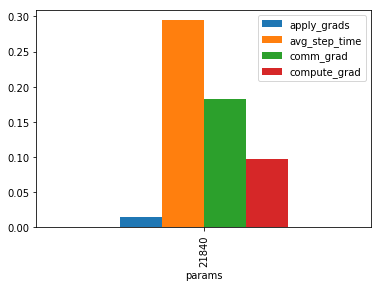

In [12]:
import pandas as pd
df = pd.DataFrame(meta)
show = df.groupby('params').mean()
show.plot.bar()

In [11]:
import numpy as np
models = [worker._model for worker in workers]
params = [dict(model.named_parameters()) for model in models]
named_params = {k: [param[k] for param in params]
                for k in params[0]}
for k, params in named_params.items():
    p0 = params[0]
    rel_errors = [torch.norm(p0 - p) / torch.norm(p)
                  for p in params]
    rel_errors = [e.item() for e in rel_errors]
    if max(rel_errors) > 2e-7:
        print(max(rel_errors))
        assert False